# **Introduction**

*   Managing risk is a big deal for businesses everywhere, especially for banks. They need to make sure they handle risk well and keep it under control.
*   This project aims to build a Machine Learning Model to assist banks in making informed decisions about credit card issuance. The model categorizes individuals into two groups: those likely to be responsible payers and those with higher risk potential. By doing so, this project empowers banks to enhance their decision-making process when extending credit cards.

## **Problem Statement**



*  Credit Applicant Prediction: Build a model to predict whether a credit card applicant is likely to be a "Good" or "Bad" customer.

*   Incorporate Various Data: Use a range of applicant information like age, income, and credit history for accurate predictions

*   Minimize Risk, Maximize Approval: Help in minimizing credit default risk and increasing the approval of trustworthy applicants.

*   Improved Decision-Making: Provide a tool that aids in making smarter credit decisions efficiently.


.












In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=0893e7f84127fd3c737501756d6ec046f66c55b07199fcc9796717ca36e61b35
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


**Importing necessary libraries**

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project").getOrCreate()

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum, round as spark_round, abs,when, expr,max
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
from pyspark.ml.feature import  VectorAssembler,StringIndexer,SQLTransformer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier,LinearSVC,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


**DATA COLLECTION :**

Obtain the relevant dataset containing information about credit card applicants and their attributes.

Importing the datasets:

**APPLICATION_RECORD**.**CSV**

In [ ]:
app_df = spark.read.csv(r"/content/application_record.csv", header=True, inferSchema=True)

In [ ]:
app_df.show()
app_df.printSchema()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -4542|         1

**CREDIT_RECORD**.**CSV**

In [ ]:
cred_df = spark.read.csv(r"/content/credit_record.csv", header=True, inferSchema=True)

In [ ]:
cred_df.show()
cred_df.printSchema()

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
|5001712|            -1|     C|
|5001712|            -2|     C|
|5001712|            -3|     C|
|5001712|            -4|     C|
|5001712|            -5|     C|
|5001712|            -6|     C|
|5001712|            -7|     C|
|5001712|            -8|     C|
|5001712|            -9|     0|
|5001712|           -10|     0|
|5001712|           -11|     0|
|5001712|           -12|     0|
|5001712|           -13|     0|
|5001712|           -14|     0|
|5001712|           -15|     0|
+-------+--------------+------+
only showing top 20 rows

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



**Data Exploration and Preprocessing:**


In [ ]:
#Checking and displaying the count of null values for each column

null_counts = app_df.select([spark_sum(col(column).isNull().cast("int")).alias(column) for column in app_df.columns])
null_counts.show()

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
| ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|                0|         0|            0|         0|              0|         0|         0|     

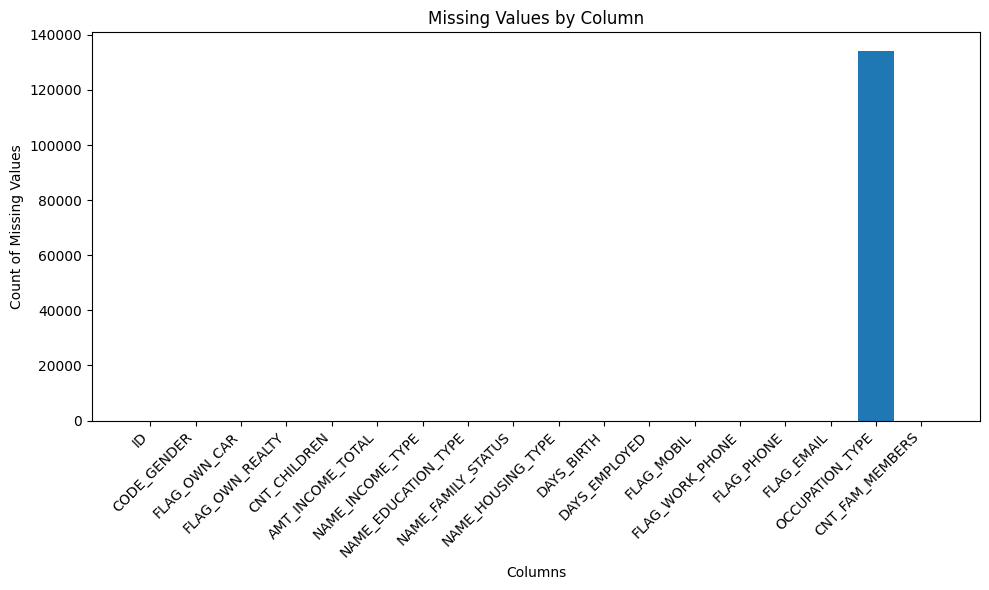

In [ ]:
# Convert the missing_counts result to a dictionary for plotting
missing_dict = null_counts.first().asDict()

# Create a bar plot to visualize missing values
plt.figure(figsize=(10, 6))
plt.bar(missing_dict.keys(), missing_dict.values())
plt.title("Missing Values by Column")
plt.xlabel("Columns")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [ ]:
# Drop the 'OCCUPATION_TYPE' column
app_df = app_df.drop('OCCUPATION_TYPE')

In [ ]:
# There are multiple enteries for the same customer , so we are removing the duplicate ID's and keeping the last entry.
app_df = app_df.dropDuplicates(['ID'])

In [ ]:
# Transform 'DAYS_BIRTH' column to 'AGE_YEARS' and round the values
app_df = app_df.withColumn('DAYS_BIRTH', spark_round(col('DAYS_BIRTH') / -365, 0)).withColumnRenamed('DAYS_BIRTH', 'AGE_YEARS')


In [ ]:
# Replace values in 'DAYS_EMPLOYED' column where value > 0 with 0
app_df = app_df.withColumn('DAYS_EMPLOYED', when(col('DAYS_EMPLOYED') > 0, 0).otherwise(col('DAYS_EMPLOYED')))

# Perform transformations on 'DAYS_EMPLOYED' and rename it to 'YEARS_EMPLOYED'
app_df = app_df.withColumn('DAYS_EMPLOYED', abs(spark_round(col('DAYS_EMPLOYED') / -365.0))).withColumnRenamed('DAYS_EMPLOYED', 'YEARS_EMPLOYED')


In [ ]:
# List of columns to drop
columns_to_drop = ['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']

# Select columns to keep
columns_to_keep = [col for col in app_df.columns if col not in columns_to_drop]
app_df = app_df.select(*columns_to_keep)

In [ ]:
app_df.show(5)

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+---------+--------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|AGE_YEARS|YEARS_EMPLOYED|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+---------+--------------+---------------+
|5008806|          M|           Y|              Y|           0|        112500.0|             Working|Secondary / secon...|             Married|House / apartment|     59.0|           3.0|            2.0|
|5008808|          F|           N|              Y|           0|        270000.0|Commercial associate|Secondary / secon...|Single / not married|House / apartment|     52.0|           8.0|  

In [ ]:
# Columns to count outliers for
columns_to_count_outliers = ['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'AGE_YEARS', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS']

# Define the IQR calculation and outlier checking using built-in functions
def calculate_outlier_stats(column):
    Q1 = app_df.approxQuantile(column, [0.25], 0)[0]
    Q3 = app_df.approxQuantile(column, [0.75], 0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = app_df.filter((col(column) < lower_bound) | (col(column) > upper_bound)).count()
    return (Q1, Q3, IQR, lower_bound, upper_bound, outliers)

# Calculate outlier statistics for each column
outliers_stats = [(column, *calculate_outlier_stats(column)) for column in columns_to_count_outliers]

# Create a Spark DataFrame from the collected statistics
outliers_df = spark.createDataFrame(outliers_stats, ['Column', 'Q1', 'Q3', 'IQR', 'Lower Bound', 'Upper Bound', 'Outliers Count'])

# Show the resulting DataFrame
outliers_df.show()

+----------------+--------+--------+--------+-----------+-----------+--------------+
|          Column|      Q1|      Q3|     IQR|Lower Bound|Upper Bound|Outliers Count|
+----------------+--------+--------+--------+-----------+-----------+--------------+
|AMT_INCOME_TOTAL|121500.0|225000.0|103500.0|   -33750.0|   380250.0|         19106|
|    CNT_CHILDREN|     0.0|     1.0|     1.0|       -1.5|        2.5|          6074|
|       AGE_YEARS|    34.0|    53.0|    19.0|        5.5|       81.5|             0|
|  YEARS_EMPLOYED|     1.0|     9.0|     8.0|      -11.0|       21.0|         17140|
| CNT_FAM_MEMBERS|     2.0|     3.0|     1.0|        0.5|        4.5|          5689|
+----------------+--------+--------+--------+-----------+-----------+--------------+



**Outlier Visualization:**

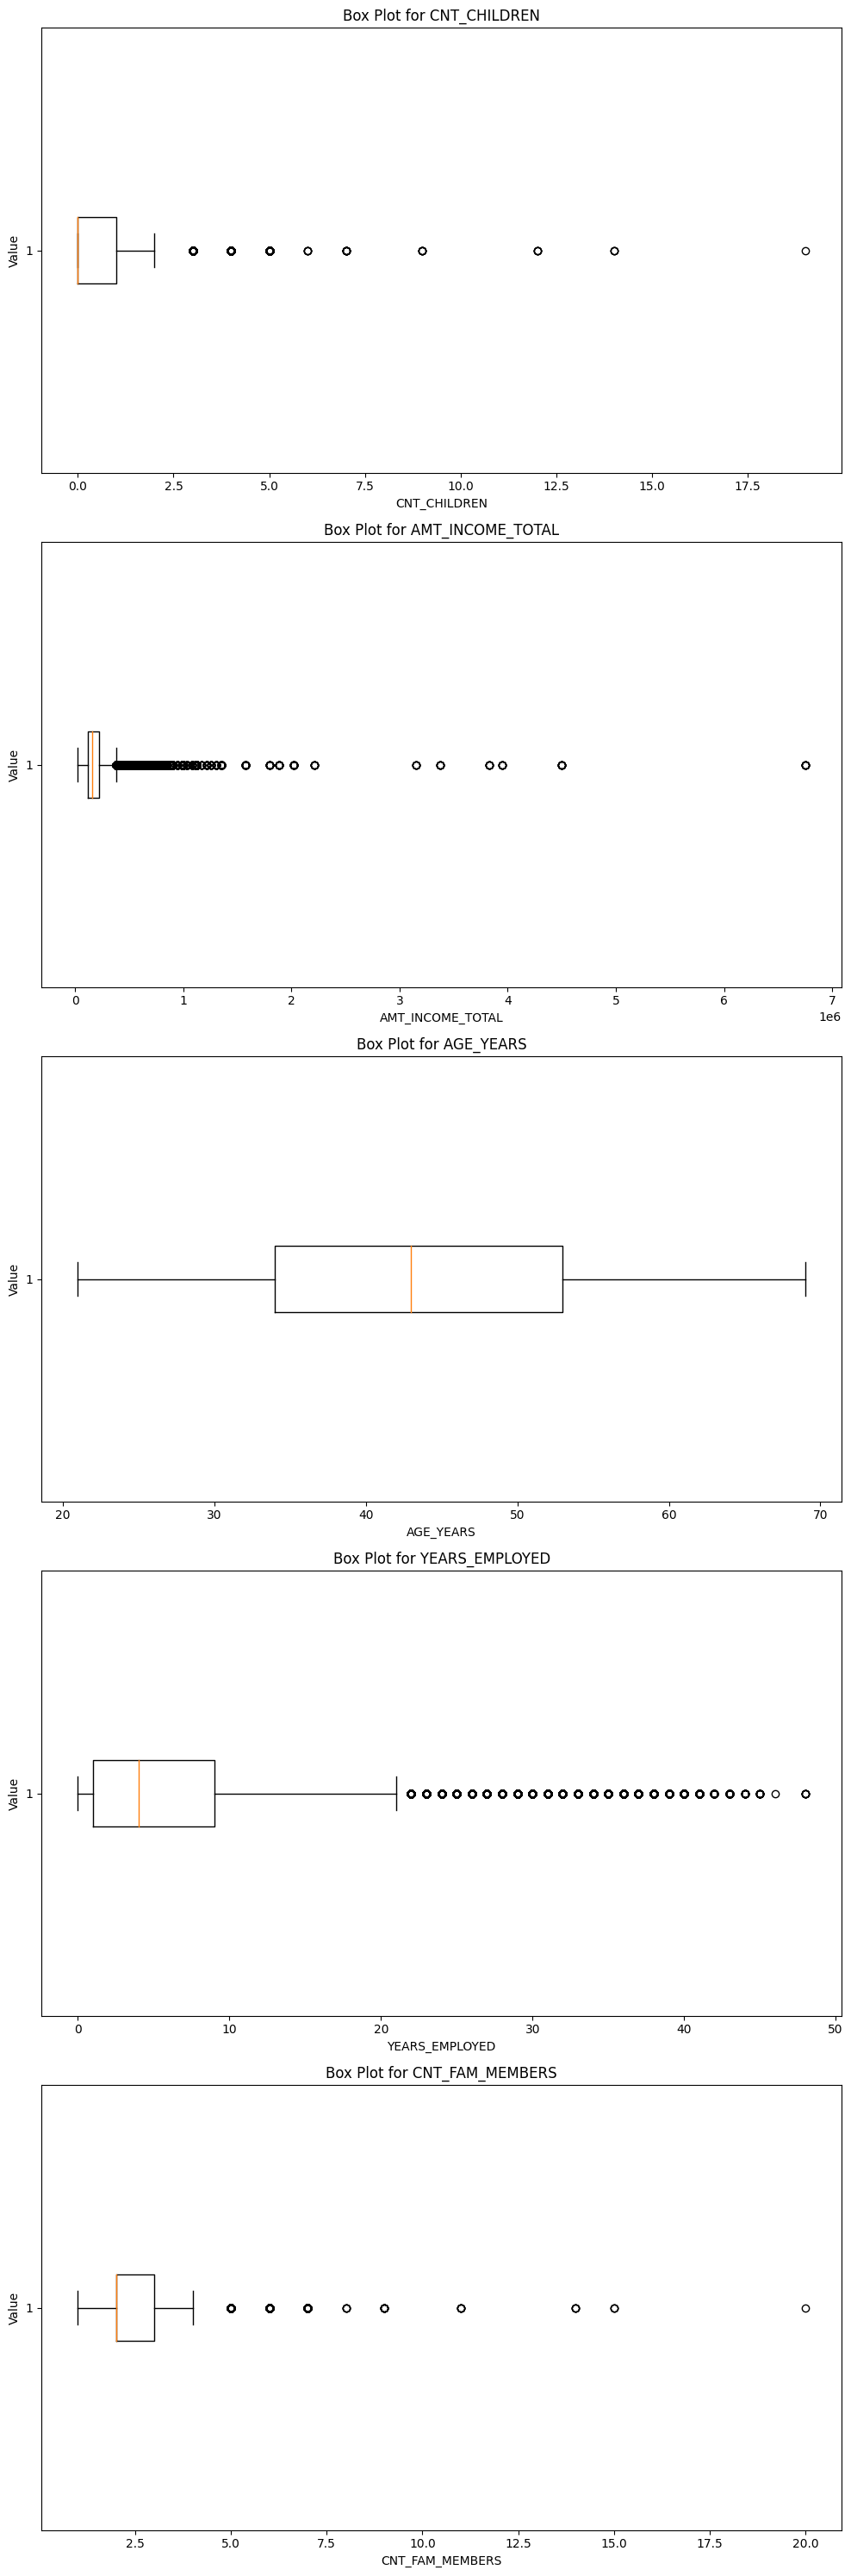

In [ ]:
# Collect data for the specified columns
columns_to_plot = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS']
data_to_plot = [app_df.select(column).rdd.flatMap(lambda x: x).collect() for column in columns_to_plot]

# Create subplots for each box plot
fig, axes = plt.subplots(nrows=len(columns_to_plot), figsize=(10, 6 * len(columns_to_plot)))

# Create box plots for each column
for ax, data, column in zip(axes, data_to_plot, columns_to_plot):
    ax.boxplot(data, vert=False)
    ax.set_xlabel(column)
    ax.set_ylabel('Value')
    ax.set_title(f'Box Plot for {column}')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [ ]:
# Calculate quantiles for the 'CNT_CHILDREN' column
high_bound_expr = expr('percentile_approx(CNT_CHILDREN, 0.999)').alias('high_bound')
low_bound_expr = expr('percentile_approx(CNT_CHILDREN, 0.001)').alias('low_bound')

# Calculate the bounds for filtering
bounds = app_df.select(high_bound_expr, low_bound_expr).first()
high_bound = bounds.high_bound
low_bound = bounds.low_bound

# Filter the DataFrame based on the calculated bounds
app_df = app_df.filter((col('CNT_CHILDREN') >= low_bound) & (col('CNT_CHILDREN') <= high_bound))


In [ ]:
# Calculate quantiles for the 'AMT_INCOME_TOTAL' column
high_bound_expr = expr('percentile_approx(AMT_INCOME_TOTAL, 0.999)').alias('high_bound')
low_bound_expr = expr('percentile_approx(AMT_INCOME_TOTAL, 0.001)').alias('low_bound')

# Calculate the bounds for filtering
bounds = app_df.select(high_bound_expr, low_bound_expr).first()
high_bound = bounds.high_bound
low_bound = bounds.low_bound

# Filter the DataFrame based on the calculated bounds
app_df = app_df.filter((col('AMT_INCOME_TOTAL') >= low_bound) & (col('AMT_INCOME_TOTAL') <= high_bound))


In [ ]:
# Calculate quantiles for the 'YEARS_EMPLOYED' column
high_bound_expr = expr('percentile_approx(YEARS_EMPLOYED, 0.999)').alias('high_bound')
low_bound_expr = expr('percentile_approx(YEARS_EMPLOYED, 0.001)').alias('low_bound')

# Calculate the bounds for filtering
bounds = app_df.select(high_bound_expr, low_bound_expr).first()
high_bound = bounds.high_bound
low_bound = bounds.low_bound

# Filter the DataFrame based on the calculated bounds
app_df = app_df.filter((col('YEARS_EMPLOYED') >= low_bound) & (col('YEARS_EMPLOYED') <= high_bound))

In [ ]:
# Calculate quantiles for the 'CNT_FAM_MEMBERS' column
high_bound_expr = expr('percentile_approx(CNT_FAM_MEMBERS, 0.999)').alias('high_bound')
low_bound_expr = expr('percentile_approx(CNT_FAM_MEMBERS, 0.001)').alias('low_bound')

# Calculate the bounds for filtering
bounds = app_df.select(high_bound_expr, low_bound_expr).first()
high_bound = bounds.high_bound
low_bound = bounds.low_bound

# Filter the DataFrame based on the calculated bounds
filtered_app_df = app_df.filter((col('CNT_FAM_MEMBERS') >= low_bound) & (col('CNT_FAM_MEMBERS') <= high_bound))

In [ ]:
# Get the number of rows (count) in the DataFrame
num_rows = app_df.count()

# Get the number of columns in the DataFrame
num_columns = len(app_df.columns)

# Display the number of rows and columns
print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 437348
Number of Columns: 13


Now we will apply Data Exploration and Preprocessing steps to other dataset i.e, Credit Record.

In [ ]:
# Replace values in the 'STATUS' column
# We need to replace our status value by 0,1 . 0 will indicate that the customer has a good credit status and
# 1 indicate that the customer has past due so it will not be consider as a good customer

cred_df = cred_df.withColumn('STATUS', when(col('STATUS').isin('C', 'X'), 0).otherwise(col('STATUS')))
cred_df = cred_df.withColumn('STATUS', when(col('STATUS').isin('2', '3', '4', '5'), 1).otherwise(col('STATUS')))

In [ ]:
# Cast the 'STATUS' column to integer data type
cred_df = cred_df.withColumn("STATUS", col("STATUS").cast("int"))

In [ ]:
# Calculate the percentage distribution of unique values in the 'STATUS' column
status_distribution = cred_df.groupBy("STATUS").count()
total_records = cred_df.count()
status_distribution = status_distribution.withColumn("Percentage", col("count") / total_records * 100)

# Show the percentage distribution
status_distribution.show()

+------+-------+------------------+
|STATUS|  count|        Percentage|
+------+-------+------------------+
|     1|  14194|1.3536466156450422|
|     0|1034381| 98.64635338435495|
+------+-------+------------------+



In [ ]:
cred_df.show()

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     0|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     0|
|5001712|            -1|     0|
|5001712|            -2|     0|
|5001712|            -3|     0|
|5001712|            -4|     0|
|5001712|            -5|     0|
|5001712|            -6|     0|
|5001712|            -7|     0|
|5001712|            -8|     0|
|5001712|            -9|     0|
|5001712|           -10|     0|
|5001712|           -11|     0|
|5001712|           -12|     0|
|5001712|           -13|     0|
|5001712|           -14|     0|
|5001712|           -15|     0|
+-------+--------------+------+
only showing top 20 rows



In [ ]:
# Calculate the count of each STATUS value for each ID
status_counts = cred_df.groupBy("ID", "STATUS").count()

# Find the majority STATUS value for each ID
majority_status = status_counts.groupBy("ID").agg({"count": "max"})
majority_status = majority_status.withColumnRenamed("max(count)", "max_count")

# Join the majority_status DataFrame with the original cred_df
cred_df = cred_df.join(majority_status, on="ID")

# Create a new column "NEW_STATUS" based on the majority value
cred_df = cred_df.withColumn("NEW_STATUS", when(col("STATUS") == 0, 0).otherwise(1))
cred_df.show()

cred_df = cred_df.drop("MONTHS_BALANCE","STATUS","max_count")
cred_df =cred_df.dropDuplicates()
cred_df = cred_df.withColumnRenamed("NEW_STATUS", "STATUS")

# Show the resulting DataFrame with the STATUS column
cred_df.show()

+-------+--------------+------+---------+----------+
|     ID|MONTHS_BALANCE|STATUS|max_count|NEW_STATUS|
+-------+--------------+------+---------+----------+
|5001711|             0|     0|        4|         0|
|5001711|            -1|     0|        4|         0|
|5001711|            -2|     0|        4|         0|
|5001711|            -3|     0|        4|         0|
|5001712|             0|     0|       19|         0|
|5001712|            -1|     0|       19|         0|
|5001712|            -2|     0|       19|         0|
|5001712|            -3|     0|       19|         0|
|5001712|            -4|     0|       19|         0|
|5001712|            -5|     0|       19|         0|
|5001712|            -6|     0|       19|         0|
|5001712|            -7|     0|       19|         0|
|5001712|            -8|     0|       19|         0|
|5001712|            -9|     0|       19|         0|
|5001712|           -10|     0|       19|         0|
|5001712|           -11|     0|       19|     

In [ ]:
# Calculate the percentage distribution of unique values in the 'MAX_STATUS' column
status_distribution = cred_df.groupBy("STATUS").count()
total_records = cred_df.count()
status_distribution = status_distribution.withColumn("Percentage", col("count") / total_records * 100)

# Show the percentage distribution
status_distribution.show()


+------+-----+------------------+
|STATUS|count|        Percentage|
+------+-----+------------------+
|     1| 5350|10.421942572174387|
|     0|45984| 89.57805742782561|
+------+-----+------------------+



In [ ]:
cred_df = cred_df.dropDuplicates()

In [ ]:
# Get the number of rows (count) in the DataFrame
num_rows = cred_df.count()

# Get the number of columns in the DataFrame
num_columns = len(cred_df.columns)

# Display the number of rows and columns
print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 51334
Number of Columns: 2


In [ ]:
cred_df.show()

+-------+------+
|     ID|STATUS|
+-------+------+
|5002116|     0|
|5002138|     0|
|5002342|     0|
|5002769|     0|
|5003210|     0|
|5003224|     0|
|5003274|     0|
|5003886|     0|
|5004015|     1|
|5004128|     0|
|5004311|     0|
|5004505|     0|
|5004643|     0|
|5004923|     1|
|5004938|     0|
|5004963|     0|
|5005140|     0|
|5005412|     0|
|5005728|     1|
|5008977|     0|
+-------+------+
only showing top 20 rows



# **Data Integration:**
**MERGING** **DATAFRAME**

In [ ]:
# Join the DataFrames based on the 'ID' column
data = app_df.join(cred_df, on='ID', how='inner')

In [ ]:
# Drop duplicates from the merged DataFrame
final_data = data.dropDuplicates()

In [ ]:
# Drop the 'ID' column
final_data = final_data.drop('ID')

In [ ]:
# Drop duplicates from the final_data DataFrame
final_data = final_data.dropDuplicates()

In [ ]:
# Get the number of rows (count) in the DataFrame
num_rows = final_data.count()

# Get the number of columns in the DataFrame
num_columns = len(final_data.columns)

# Display the number of rows and columns
print("Number of Rows:", num_rows)
print("Number of Columns:", num_columns)

Number of Rows: 11757
Number of Columns: 13


In [ ]:
final_data.show(5)

+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+---------+--------------+---------------+------+
|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|AGE_YEARS|YEARS_EMPLOYED|CNT_FAM_MEMBERS|STATUS|
+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+---------+--------------+---------------+------+
|          M|           Y|              Y|           3|        270000.0|             Working|Secondary / secon...|             Married|House / apartment|     35.0|           3.0|            5.0|     0|
|          F|           N|              N|           0|        135000.0|Commercial associate|Secondary / secon...|      Civil marriage|House / apartment|     43.0|           1.0|            2.

**Data Encoding**

**Ordinal Encoding of 'EDUCATION_TYPE' Column:**

In [ ]:
# Define the ordinal categories and their corresponding codes
ordinal_categories = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}

# Convert 'EDUCATION_TYPE' column to ordinal codes based on the defined categories
final_data = final_data.withColumn("NAME_EDUCATION_TYPE",
                                   expr("CASE " +
                                        "WHEN NAME_EDUCATION_TYPE = 'Lower secondary' THEN 0 " +
                                        "WHEN NAME_EDUCATION_TYPE = 'Secondary / secondary special' THEN 1 " +
                                        "WHEN NAME_EDUCATION_TYPE = 'Incomplete higher' THEN 2 " +
                                        "WHEN NAME_EDUCATION_TYPE = 'Higher education' THEN 3 " +
                                        "WHEN NAME_EDUCATION_TYPE = 'Academic degree' THEN 4 " +
                                        "ELSE NULL END"))



**Label Encoding using StringIndexer**

In [ ]:

# List of columns to be label encoded
columns = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

# Create a list of StringIndexer stages for binary columns
indexer_stages = [StringIndexer(inputCol=col, outputCol=col + "_INDEX", handleInvalid="keep")
                  for col in columns]

# Create a pipeline with the StringIndexer stages
pipeline = Pipeline(stages=indexer_stages)

# Fit and transform the pipeline on the DataFrame
final_data = pipeline.fit(final_data).transform(final_data)



In [ ]:
# List of columns to drop
columns_to_drop = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

# Select columns to keep
columns_to_keep = [col for col in final_data.columns if col not in columns_to_drop]
final_data = final_data.select(*columns_to_keep)

In [ ]:
final_data.show(5)

+------------+----------------+-------------------+---------+--------------+---------------+------+-----------------+------------------+---------------------+----------------------+------------------------+-----------------------+
|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_EDUCATION_TYPE|AGE_YEARS|YEARS_EMPLOYED|CNT_FAM_MEMBERS|STATUS|CODE_GENDER_INDEX|FLAG_OWN_CAR_INDEX|FLAG_OWN_REALTY_INDEX|NAME_INCOME_TYPE_INDEX|NAME_FAMILY_STATUS_INDEX|NAME_HOUSING_TYPE_INDEX|
+------------+----------------+-------------------+---------+--------------+---------------+------+-----------------+------------------+---------------------+----------------------+------------------------+-----------------------+
|           3|        270000.0|                  1|     35.0|           3.0|            5.0|     0|              1.0|               1.0|                  0.0|                   0.0|                     0.0|                    0.0|
|           0|        135000.0|                  1|     43.0|           1.0|

In [ ]:
# Dictionary to map old column names to new column names
new_column_names = {
    'CODE_GENDER_INDEX': 'GENDER',
    'FLAG_OWN_CAR_INDEX': 'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY_INDEX': 'FLAG_OWN_REALTY',
    'CNT_CHILDREN': 'CNT_CHILDREN',
    'AMT_INCOME_TOTAL': 'INCOME',
    'NAME_INCOME_TYPE_INDEX': 'INCOME_TYPE',
    'NAME_EDUCATION_TYPE': 'EDUCATION_TYPE',
    'NAME_FAMILY_STATUS_INDEX': 'MARRIAGE_STATUS',
    'NAME_HOUSING_TYPE_INDEX': 'HOUSING_TYPE',
    'AGE_YEARS': 'AGE',
    'YEARS_EMPLOYED': 'YEARS_EMPLOYED',
    'CNT_FAM_MEMBERS': 'CNT_FAM_MEMBERS',
    'STATUS': 'STATUS'
}

# Rename columns in the final_data DataFrame using the dictionary
for old_name, new_name in new_column_names.items():
    final_data = final_data.withColumnRenamed(old_name, new_name)

In [ ]:
# List of columns to convert
columns_to_convert = ['GENDER', 'AGE', 'YEARS_EMPLOYED','FLAG_OWN_CAR','FLAG_OWN_REALTY','INCOME_TYPE','MARRIAGE_STATUS','HOUSING_TYPE']

# Convert specified columns from decimal to integer
for column in columns_to_convert:
    final_data = final_data.withColumn(column, F.col(column).cast("int"))

# Show the resulting DataFrame with converted columns
final_data.show()

+------------+--------+--------------+---+--------------+---------------+------+------+------------+---------------+-----------+---------------+------------+
|CNT_CHILDREN|  INCOME|EDUCATION_TYPE|AGE|YEARS_EMPLOYED|CNT_FAM_MEMBERS|STATUS|GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|INCOME_TYPE|MARRIAGE_STATUS|HOUSING_TYPE|
+------------+--------+--------------+---+--------------+---------------+------+------+------------+---------------+-----------+---------------+------------+
|           3|270000.0|             1| 35|             3|            5.0|     0|     1|           1|              0|          0|              0|           0|
|           0|135000.0|             1| 43|             1|            2.0|     0|     0|           0|              1|          1|              2|           0|
|           0|225000.0|             1| 53|            12|            1.0|     0|     0|           0|              1|          0|              1|           0|
|           0|157500.0|             1| 30|          

In [ ]:
final_data.printSchema()

root
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- INCOME: double (nullable = true)
 |-- EDUCATION_TYPE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- YEARS_EMPLOYED: integer (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- STATUS: integer (nullable = false)
 |-- GENDER: integer (nullable = true)
 |-- FLAG_OWN_CAR: integer (nullable = true)
 |-- FLAG_OWN_REALTY: integer (nullable = true)
 |-- INCOME_TYPE: integer (nullable = true)
 |-- MARRIAGE_STATUS: integer (nullable = true)
 |-- HOUSING_TYPE: integer (nullable = true)



**SPLITING** **DATASET**

In [ ]:
final_data1 = final_data

In [ ]:
# Prepare features and labels
feature_columns = [col for col in final_data1.columns if col != 'STATUS']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
final_data1 = assembler.transform(final_data1)

# Perform train-test split
train_ratio = 0.8
test_ratio = 1.0 - train_ratio
train_data, test_data = final_data1.randomSplit([train_ratio, test_ratio], seed=22)

# Define label column
label_column = "STATUS"


In [ ]:
final_data1.show(5)

+------------+--------+--------------+---+--------------+---------------+------+------+------------+---------------+-----------+---------------+------------+--------------------+
|CNT_CHILDREN|  INCOME|EDUCATION_TYPE|AGE|YEARS_EMPLOYED|CNT_FAM_MEMBERS|STATUS|GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|INCOME_TYPE|MARRIAGE_STATUS|HOUSING_TYPE|            features|
+------------+--------+--------------+---+--------------+---------------+------+------+------------+---------------+-----------+---------------+------------+--------------------+
|           3|270000.0|             1| 35|             3|            5.0|     0|     1|           1|              0|          0|              0|           0|[3.0,270000.0,1.0...|
|           0|135000.0|             1| 43|             1|            2.0|     0|     0|           0|              1|          1|              2|           0|[0.0,135000.0,1.0...|
|           0|225000.0|             1| 53|            12|            1.0|     0|     0|           0|     

**LOGISTIC** **REGRESSION**

In [ ]:
# Build a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol=label_column)

# Create a pipeline with the logistic regression model
pipeline = Pipeline(stages=[lr])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator_multiclass = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")

# Calculate accuracy
accuracy = evaluator_multiclass.evaluate(predictions)

# Print the accuracy and other metrics
print("Logistic Model Accuracy:", accuracy * 100, "%")


Logistic Model Accuracy: 80.05093378607809 %


**DECISION TREE CLASSIFICATION**

In [ ]:
# Build a Decision Tree model
dt_classifier = DecisionTreeClassifier(labelCol=label_column, featuresCol="features", maxDepth=10, minInstancesPerNode=8)

# Train the model
dt_model = dt_classifier.fit(train_data)

# Make predictions on the test set
predictions = dt_model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator_multiclass = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")

# Calculate accuracy
accuracy = evaluator_multiclass.evaluate(predictions)

# Print the accuracy and other metrics
print("Decision Tree Model Accuracy:", accuracy * 100, "%")

Decision Tree Model Accuracy: 78.73514431239389 %


**RANDOM FOREST CLASSIFICATION**


In [ ]:
# Build a Random Forest model
rf_classifier = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=100, maxDepth=5, minInstancesPerNode=4)

# Train the model
rf_model = rf_classifier.fit(train_data)

# Make predictions on the test set
predictions = rf_model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator_multiclass = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")

# Calculate accuracy
accuracy = evaluator_multiclass.evaluate(predictions)

# Print the accuracy and other metrics
print("Random Forest Model Accuracy:", accuracy * 100, "%")

Random Forest Model Accuracy: 80.05093378607809 %


**SUPPORT VECTOR MACHINE CLASSIFICATION**

In [ ]:

# Build a Support Vector Machine (SVM) model
svm_classifier = LinearSVC(labelCol=label_column, featuresCol="features")

# Train the model
svm_model = svm_classifier.fit(train_data)

# Make predictions on the test set
predictions = svm_model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator_multiclass = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")

# Calculate accuracy
accuracy = evaluator_multiclass.evaluate(predictions)

# Print the accuracy and other metrics
print("Support Vector Classifier Accuracy:", accuracy * 100, "%")

Support Vector Classifier Accuracy: 80.05093378607809 %


**XGBOOST  CLASSIFICATION**

In [ ]:
# Build an XGBoost model (GBTClassifier in PySpark)
xgb_classifier = GBTClassifier(labelCol=label_column, featuresCol="features")

# Train the model
xgb_model = xgb_classifier.fit(train_data)

# Make predictions on the test set
predictions = xgb_model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator_multiclass = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")

# Calculate accuracy
accuracy = evaluator_multiclass.evaluate(predictions)

# Print the accuracy and other metrics
print("XGBoost Model Accuracy:", accuracy * 100, "%")

XGBoost Model Accuracy: 79.45670628183362 %


Logistic Model Accuracy : 80.05 %

DecisionTree Model Accuracy : 78.73 %

Random Forest Model Accuracy : 80.05 %

Support Vector Classifier Accuracy : 80.05 %

XGBoost Model Accuracy : 79.45 %

Converting Dataset from pyspark to pandas

In [ ]:
final_data2 = final_data

In [ ]:
# Collect PySpark DataFrame data to the driver node and convert to pandas DataFrame
final_Data = final_data2.collect()

# Now final_data_pandas is a list of Row objects. You can convert it to a pandas DataFrame
import pandas as pd
final_Data = pd.DataFrame(final_Data)

In [ ]:
final_Data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3,270000.0,1,35,3,5.0,0,1,1,0,0,0,0
1,0,135000.0,1,43,1,2.0,0,0,0,1,1,2,0
2,0,225000.0,1,53,12,1.0,0,0,0,1,0,1,0
3,0,157500.0,1,30,1,1.0,0,1,0,0,0,1,0
4,1,144000.0,3,37,0,3.0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11752,1,135000.0,1,34,4,3.0,1,1,1,0,0,0,0
11753,0,225000.0,3,30,1,1.0,0,1,1,0,1,1,0
11754,2,135000.0,3,37,6,4.0,0,1,1,0,0,0,0
11755,0,112500.0,1,58,2,1.0,0,0,1,0,0,4,0


In [ ]:
new_column_names = {

    0: 'CNT_CHILDREN',
    1: 'INCOME',
    2: 'EDUCATION_TYPE',
    3: 'AGE',
    4: 'YEARS_EMPLOYED',
    5: 'CNT_FAM_MEMBERS',
    6: 'STATUS',
    7: 'GENDER',
    8: 'FLAG_OWN_CAR',
    9: 'FLAG_OWN_REALTY',
    10: 'INCOME_TYPE',
    11: 'MARRIAGE_STATUS',
    12: 'HOUSING_TYPE '

}

# Use the rename() method to rename columns
final_Data.rename(columns=new_column_names, inplace=True)

Libraries Required after converting to Pandas Dataframe

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

**SPLITING DATASET**

In [ ]:
X = final_Data.drop(['STATUS'], axis=1)
y = final_Data['STATUS']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 22)

**BALANCING DATASET**

In [ ]:
# scaling all features
MMS = MinMaxScaler()
X_train_scaled = pd.DataFrame(MMS.fit_transform(X_train), columns= X_train.columns)
X_test_scaled = pd.DataFrame(MMS.transform(X_test), columns= X_test.columns)

In [ ]:
# adding samples to minority class using SMOTE
oversample = SMOTE()

X_train_oversam, y_train_oversam = oversample.fit_resample(X_train_scaled, y_train)
X_test_oversam, y_test_oversam = oversample.fit_resample(X_test_scaled, y_test)

**Machine Learning Model after Balancing**

**LOGISTIC REGRESSION**

In [ ]:
# Logistic Regression

log_model = LogisticRegression()
log_model.fit(X_train_oversam, y_train_oversam)

predict_lr = log_model.predict(X_test_oversam)
print('Logistic Model Accuracy : ', accuracy_score(y_test_oversam, predict_lr)*100, '%')

print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, predict_lr))

print('\nClassification report:')
print(classification_report(y_test_oversam, predict_lr))

Logistic Model Accuracy :  49.758842443729904 %

Confusion matrix :
[[953 913]
 [962 904]]

Classification report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      1866
           1       0.50      0.48      0.49      1866

    accuracy                           0.50      3732
   macro avg       0.50      0.50      0.50      3732
weighted avg       0.50      0.50      0.50      3732



**DECISION TREE CLASSIFICATION**

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [2,4, 6,8,10,12,14,16,18,20],  # Adjust these values based on your domain knowledge
    'min_samples_split': [2, 4,6,8, 10],
    'min_samples_leaf': [2, 4,6,8,10]
}

# Create an instance of the Decision Tree model
base_decision_model = DecisionTreeClassifier()

# Create a GridSearchCV instance with the Decision Tree model and parameter grid
grid_search = GridSearchCV(base_decision_model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_oversam, y_train_oversam)

# Get the best Decision Tree model from the grid search
best_decision_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions on the test data using the best Decision Tree model
pred_dt = best_decision_model.predict(X_test_oversam)

# Calculate and print the accuracy of the best Decision Tree model
accuracy = accuracy_score(y_test_oversam, pred_dt) * 100
print('Best Decision Tree Model Accuracy:', accuracy, '%')

# Print the confusion matrix
print('\nConfusion matrix:')
print(confusion_matrix(y_test_oversam, pred_dt))

# Print the classification report
print('\nClassification report:')
print(classification_report(y_test_oversam, pred_dt))

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 6}
Best Decision Tree Model Accuracy: 76.58092175777064 %

Confusion matrix:
[[1590  276]
 [ 598 1268]]

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.78      1866
           1       0.82      0.68      0.74      1866

    accuracy                           0.77      3732
   macro avg       0.77      0.77      0.76      3732
weighted avg       0.77      0.77      0.76      3732



**RANDOM FOREST CLASSIFICATION**

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 150,200],  # Adjust the number of estimators
    'max_depth': [5, 10, 15],   # Adjust these values based on your domain knowledge
    'min_samples_leaf': [4,6,8]
}

# Create an instance of the Random Forest model
base_rf_model = RandomForestClassifier()

# Create a GridSearchCV instance with the Random Forest model and parameter grid
grid_search = GridSearchCV(base_rf_model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train_oversam, y_train_oversam)

# Get the best Random Forest model from the grid search
best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions on the test data using the best Random Forest model
pred_rf = best_rf_model.predict(X_test_oversam)

# Calculate and print the accuracy of the best Random Forest model
accuracy = accuracy_score(y_test_oversam, pred_rf) * 100
print('Best Random Forest Model Accuracy:', accuracy, '%')

# Print the confusion matrix
print('\nConfusion matrix:')
print(confusion_matrix(y_test_oversam, pred_rf))

# Print the classification report
print('\nClassification report:')
print(classification_report(y_test_oversam, pred_rf))

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 200}
Best Random Forest Model Accuracy: 75.45551982851019 %

Confusion matrix:
[[1589  277]
 [ 639 1227]]

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.78      1866
           1       0.82      0.66      0.73      1866

    accuracy                           0.75      3732
   macro avg       0.76      0.75      0.75      3732
weighted avg       0.76      0.75      0.75      3732



**SUPPORT VECTOR MACHINE CLASSIFICATION**

In [ ]:
# Support Vector Machine classification

svc_model = SVC()

svc_model.fit(X_train_oversam, y_train_oversam)

pred_svc = svc_model.predict(X_test_oversam)
print('Support Vector Classifier Accuracy : ', accuracy_score(y_test_oversam, pred_svc)*100, '%')

print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, pred_svc))

print('\nClassification report:')
print(classification_report(y_test_oversam, pred_svc))


Support Vector Classifier Accuracy :  50.61629153269025 %

Confusion matrix :
[[ 853 1013]
 [ 830 1036]]

Classification report:
              precision    recall  f1-score   support

           0       0.51      0.46      0.48      1866
           1       0.51      0.56      0.53      1866

    accuracy                           0.51      3732
   macro avg       0.51      0.51      0.50      3732
weighted avg       0.51      0.51      0.50      3732



**XGBOOST CLASSIFICATION**

In [ ]:
# XGBoost  classification

XGB_model = XGBClassifier()

XGB_model.fit(X_train_oversam, y_train_oversam)

predict_xgb = XGB_model.predict(X_test_oversam)
print('XGBoost Model Accuracy : ', accuracy_score(y_test_oversam, predict_xgb)*100, '%')

print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, predict_xgb))

print('\nClassification report:')
print(classification_report(y_test_oversam, predict_xgb))


XGBoost Model Accuracy :  84.35155412647374 %

Confusion matrix :
[[1772   94]
 [ 490 1376]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1866
           1       0.94      0.74      0.82      1866

    accuracy                           0.84      3732
   macro avg       0.86      0.84      0.84      3732
weighted avg       0.86      0.84      0.84      3732



Logistic Model Accuracy : 49.75 %

DecisionTree Model Accuracy : 76.58 %

Random Forest Model Accuracy : 75.45 %

Support Vector Classifier Accuracy : 50.61 %

XGBoost Model Accuracy : 84.35 %

## **Conclusion**

As we have seen that, XGBoost Model is giving highest accuracy of 84.35 %, hence we will use XGBoost Model for predicion